### Visualise Flow ODE

In [38]:
from experiments.flow_matching.cfm import FlowConfig, Flow
from experiments.base import RESOURCES

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as ani
from matplotlib.collections import PathCollection

from pathlib import Path

from torch import Tensor
import torch
import numpy as np

plt.rcParams['text.usetex'] = False

# %matplotlib widget

In [2]:
model_name = "20250113-230712"

save_path = RESOURCES / "models" / "flow" / model_name / "model"

assert save_path.exists()

In [3]:
# Load model

model = Flow.load_model(save_path)

/workspaces/NNs-and-Deep-Learning/experiments/base.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=DEVICE)


In [36]:
n_steps = 60
batch = 300
samples, time_steps = model.sample(batch, n_steps)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


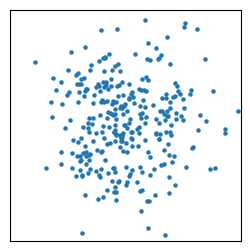

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

scat = ax.scatter(samples[0, :, 0], samples[0, :, 1], s=5)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')
# remove axis
ax.set_xticks([])
ax.set_yticks([])

def update(frame):
    frame = min(frame, n_steps - 1) # clip to n_steps
    scat.set_offsets(samples[frame])
    return scat,

anim = ani.FuncAnimation(fig, update, frames=range(n_steps + 500), blit=False, interval=1)
# ani.save(RESOURCES / "figures" / "flow" / f"{model_name}.gif", writer='imagemagick', fps=10)
anim.save(f"moons_flow.gif", writer='imagemagick')

### Visualise as a vector field

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


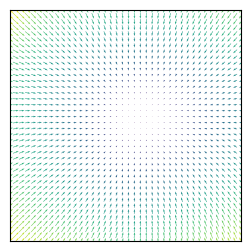

In [71]:
n_steps = 20
time_steps = torch.linspace(0., 1., n_steps + 1)

gridpoints = 40
X = torch.linspace(-3, 3, gridpoints)
Y = torch.linspace(-3, 3, gridpoints)

X, Y = torch.meshgrid(X, Y)

X = X.ravel()
Y = Y.ravel()

grid = torch.stack([X, Y], dim=-1)

samples = [
    model.step(grid, time_steps[i], time_steps[i + 1])
    for i in range(n_steps)
]

def uvm_at_idx(i):
    delta = samples[i] - grid
    U = delta[:, 0].reshape(gridpoints, gridpoints)
    V = delta[:, 1].reshape(gridpoints, gridpoints)
    M = torch.sqrt(U**2 + V**2) # magnitude
    return U, V, M


fig, ax = plt.subplots(1, 1, figsize=(3, 3))
U, V, M = uvm_at_idx(0)
Q = ax.quiver(X, Y, U, V, M, scale=1, scale_units='xy', pivot='mid')

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')
# remove axis
ax.set_xticks([])
ax.set_yticks([])

def update(step):
    step = min(step, len(samples) - 1)
    U, V, M = uvm_at_idx(step)
    Q.set_UVC(U, V, M)
    return Q,


# ax.quiver(X, Y, U, V, M, scale=1, scale_units='xy', pivot='mid')
# plt.show()

anim = ani.FuncAnimation(fig, update, frames=range(n_steps + 50), blit=False, interval=100)
anim.save(f"moons_field.gif", writer='imagemagick')